## Env

In [8]:
%load_ext autoreload
%load_ext dotenv
%dotenv -o

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [9]:
%%capture
%pip install langchain langchain_community
%pip install faiss-gpu faiss-cpu
%pip install langchain-cohere
%pip install langgraph
%pip install langchain-google-community

In [10]:
import os

current_directory = os.getcwd()

workspace_directory = os.path.abspath(os.path.join(current_directory, ".."))
print(workspace_directory)

/home/izlobin/wd/events-planner-agents


## Domain

In [11]:
from typing import TypedDict, Annotated, List, Union
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    # user_info: str

## Utilities

In [12]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


llm = ChatOpenAI(api_key=os.getenv("OPENAI_API_KEY"), model=os.getenv("OPENAI_API_MODEL_NAME", "gpt-4o-mini"))


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

## Tools

In [ ]:
# from langchain_anthropic import ChatAnthropic
from datetime import date, datetime
from typing import Any, Dict, Optional

import boto3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph
from opensearchpy import OpenSearch, RequestsHttpConnection
from pydantic import BaseModel, Field
from requests_aws4auth import AWS4Auth

# Constants
OPENSEARCH_URL = "https://search-manual-test-fczgibvrlzm6dobny7dhtzpqmq.aos.us-east-1.on.aws"
ALL_EVENTS_INDEX = "all-events"

# Global client variable
_client = None


def get_client() -> OpenSearch:
    """Get or create an OpenSearch client with AWS authentication."""
    global _client
    if _client:
        return _client

    # Use boto3's default credential chain (mimics TypeScript's defaultProvider)
    session = boto3.Session()
    credentials = session.get_credentials()
    if not credentials:
        raise ValueError("No AWS credentials found. Ensure AWS CLI is configured or use an IAM role.")

    aws_auth = AWS4Auth(
        credentials.access_key,
        credentials.secret_key,
        "us-east-1",  # Match TypeScript region
        "es",  # Service name for OpenSearch
        session_token=credentials.token if credentials.token else None,
    )

    _client = OpenSearch(
        hosts=[{"host": OPENSEARCH_URL.replace("https://", ""), "port": 443}],
        http_auth=aws_auth,
        use_ssl=True,
        verify_certs=True,
        connection_class=RequestsHttpConnection,
    )

    # Test connection
    if not _client.ping():
        raise ConnectionError("Failed to connect to OpenSearch at " + OPENSEARCH_URL)

    return _client


@tool
def search_events(
    start_time: Optional[date | datetime] = None,
    end_time: Optional[date | datetime] = None,
    limit: int = 10,
    sort: Optional[list[Dict[str, Any]]] = None,
    additional_fields: Optional[list[str]] = None,
) -> list[dict]:
    """Search for events based on the event time range."""
    client = get_client()
    search_params = {
        "index": ALL_EVENTS_INDEX,
        "size": limit,
        "body": {
            "_source": [
                "url",
                "dateStart",
                "dateEnd",
                "title",
                "hosts",
                "group",
                "address",
                "guests",
                "attendees",
                "shortDescription",
                "cover",
                "tags",
                "venue",
                "online",
                "price",
                "spotsLeft",
            ]
            + (additional_fields if additional_fields else []),
            "query": {
                "function_score": {
                    "query": {
                        "bool": {
                            "must": [
                                {
                                    "range": {
                                        "dateStart": {
                                            "gte": start_time.isoformat() if start_time else "now",
                                            "lte": end_time.isoformat() if end_time else "now+14d/d",
                                            "format": "strict_date_optional_time",
                                        }
                                    }
                                }
                            ]
                        }
                    },
                    "script_score": {
                        "script": {
                            "source": """
                                double compositeScore = 0;
                                compositeScore += doc['popularity'].value * 0.1;
                                compositeScore += doc['uniqueness'].value * 0.2;
                                compositeScore += doc['venue_niceness'].value * 0.15;
                                compositeScore += doc['free_admision'].value * 0.2;
                                compositeScore += doc['drinks_provided'].value * 0.1;
                                compositeScore += doc['food_provided'].value * 0.1;
                                compositeScore += doc['quietness'].value * 0.05;
                                compositeScore += doc['proximity'].value * 0.05;
                                compositeScore += doc['non_commercial'].value * 0.025;
                                compositeScore += doc['no_additional_expenses'].value * 0.025;
                                
                                // Normalize composite score to be between 0 and 1
                                compositeScore = Math.min(Math.max(compositeScore, 0), 1);
                                
                                // Adjust the initial score based on the composite score
                                double adjustmentFactor = 1 + (compositeScore - 0.5) * 2;
                                return _score * adjustmentFactor;
                            """
                        }
                    },
                }
            },
            "sort": sort if sort else [{"_score": "desc"}, {"_id": "asc"}],
        },
    }

    response = client.search(**search_params)
    results = [{"id": hit["_id"], **hit["_source"]} for hit in response["hits"]["hits"]]

    return results


safe_tools = [
    search_events,
]

sensitive_tools = []
sensitive_tool_names = {t.name for t in sensitive_tools}

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant for an events planning application. Your primary role is to search for event information and assist users with booking events. "
            "If a user requests to update or cancel an event booking, delegate the task to the appropriate specialized assistant by invoking the corresponding tool. "
            "You are not able to make these types of changes yourself. Only the specialized assistants are given permission to do this for the user. "
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "Provide detailed information to the user, and always double-check the database before concluding that information is unavailable. "
            "When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If a search comes up empty, expand your search before giving up."
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

assistant_runnable = assistant_prompt | llm.bind_tools(safe_tools + sensitive_tools)

In [16]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait


# Example of using a selenium web browser to book an event without API

@tool
def book_event(url: str) -> dict:
    """
    Book an event by navigating to the provided URL and completing the booking process.

    Args:
        url (str): The URL of the event booking page.

    Returns:
        dict: A dictionary containing the booking confirmation details.
    """
    # Set up headless browser options
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")

    # Initialize the WebDriver
    driver = webdriver.Chrome(options=chrome_options)

    try:
        # Open the event booking page
        driver.get(url)

        # Wait for the page to load and find the "Join" button
        join_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Join')]")))
        join_button.click()

        # Fill out the booking form with user details
        for field, value in user_details.items():
            input_element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.NAME, field)))
            input_element.clear()
            input_element.send_keys(value)

        # Submit the booking form
        submit_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Confirm')]")))
        submit_button.click()

        # Wait for the confirmation message
        confirmation_message = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//div[contains(@class, 'confirmation-message')]")))

        # Return the confirmation details
        return {"status": "success", "message": confirmation_message.text}

    except Exception as e:
        return {"status": "error", "message": str(e)}

    finally:
        # Close the browser
        driver.quit()

In [ ]:
from langchain.community.tools.google_calendar import GoogleCalendarViewTool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from datetime import datetime
import os

# Define Google Calendar parameters
google_calendar_params = {
    "credentials": {
        "clientEmail": os.getenv("GOOGLE_CALENDAR_CLIENT_EMAIL"),
        "privateKey": os.getenv("GOOGLE_CALENDAR_PRIVATE_KEY"),
        "calendarId": os.getenv("GOOGLE_CALENDAR_CALENDAR_ID"),
    },
    "scopes": [
        "https://www.googleapis.com/auth/calendar",
        "https://www.googleapis.com/auth/calendar.events",
    ],
    "model": llm,
}

# Initialize the Google Calendar view tool
google_calendar_view_tool = GoogleCalendarViewTool(google_calendar_params)

@tool
def view_calendar_availability(start_time: Optional[datetime] = None, end_time: Optional[datetime] = None) -> dict:
    """
    View calendar availability within a specified time range.

    Args:
        start_time (Optional[datetime]): The start time of the range to view availability.
        end_time (Optional[datetime]): The end time of the range to view availability.

    Returns:
        dict: A dictionary containing the calendar availability details.
    """
    view_input = {
        "start_time": start_time.isoformat() if start_time else None,
        "end_time": end_time.isoformat() if end_time else None,
    }

    view_result = google_calendar_view_tool.invoke({
        "messages": [{"role": "user", "content": view_input}],
    })

    return view_result

# Example usage
view_input = "What meetings do I have this week?"

view_result = view_calendar_availability(start_time=datetime.now(), end_time=datetime.now() + timedelta(days=7))

print("View Result", view_result)

ModuleNotFoundError: No module named 'langchain_community.tools.google_calendar'

## Assistant

In [ ]:
from langchain_community.tools.google_calendar import GoogleCalendarCreateTool, GoogleCalendarViewTool

# Define Google Calendar parameters
google_calendar_params = {
    "credentials": {
        "clientEmail": os.getenv("GOOGLE_CALENDAR_CLIENT_EMAIL"),
        "privateKey": os.getenv("GOOGLE_CALENDAR_PRIVATE_KEY"),
        "calendarId": os.getenv("GOOGLE_CALENDAR_CALENDAR_ID"),
    },
    "scopes": [
        "https://www.googleapis.com/auth/calendar",
        "https://www.googleapis.com/auth/calendar.events",
    ],
    "model": llm,
}

# Initialize the tools
# google_calendar_create_tool = GoogleCalendarCreateTool(google_calendar_params)
google_calendar_view_tool = GoogleCalendarViewTool(google_calendar_params)

# Calendar assistant prompt
calendar_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for managing calendar availability. "
            "The primary assistant delegates work to you whenever the user needs help identifying gaps in their calendar. "
            "Your sole purpose is to identify availability gaps in the user's calendar. "
            "When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            "Remember that a task isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

# Calendar Assistant
calendar_safe_tools = [google_calendar_view_tool]
calendar_sensitive_tools = []
calendar_tools = calendar_safe_tools + calendar_sensitive_tools
calendar_runnable = calendar_assistant_prompt | llm.bind_tools(calendar_tools)


# Calendar Assistant class
class ToCalendarAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle calendar management."""

    task: str = Field(description="The task the user wants to perform on their calendar.")
    details: str = Field(description="Any additional information or requests from the user regarding the calendar task.")

    class Config:
        json_schema_extra = {
            "example": {
                "task": "Identify gaps",
                "details": "Find gaps in my calendar for the next week.",
            }
        }

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph
from pydantic import BaseModel, Field


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (not result.content or isinstance(result.content, list) and not result.content[0].get("text")):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }


# Event booking assistant

event_booking_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling event bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking events. "
            "Search for available events based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Event booking confirmed!'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

# Event Booking Assistant
event_booking_safe_tools = [search_events]
# event_booking_sensitive_tools = [sign_up_for_event]
event_booking_sensitive_tools = []
event_booking_tools = event_booking_safe_tools + event_booking_sensitive_tools
event_booking_runnable = event_booking_prompt | llm.bind_tools(event_booking_tools + [CompleteOrEscalate])


# Event Booking Assistant
class ToEventBookingAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle event bookings."""

    event_name: str = Field(description="The name of the event the user wants to book.")
    event_date: str = Field(description="The date of the event the user wants to book.")
    location: str = Field(description="The location of the event.")
    request: str = Field(description="Any additional information or requests from the user regarding the event booking.")

    class Config:
        json_schema_extra = {
            "example": {
                "event_name": "Concert",
                "event_date": "2023-09-10",
                "location": "New York",
                "request": "I would like front row seats if available.",
            }
        }


# The top-level assistant performs general Q&A and delegates specialized tasks to other assistants.
# The task delegation is a simple form of semantic routing / does simple intent detection
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant for an events planning application. "
            "Your primary role is to search for event information and assist users with booking events. "
            "If a user requests to update or cancel an event booking, book a car rental, book a hotel, or get trip recommendations, "
            "delegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself."
            " Only the specialized assistants are given permission to do this for the user."
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "Provide detailed information to the user, and always double-check the database before concluding that information is unavailable. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

In [ ]:
primary_assistant_tools = [
    search_events,
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToEventBookingAssistant,
    ]
)

## Graph

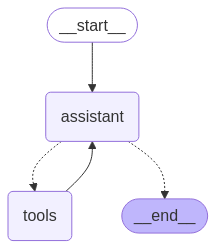

In [44]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(primary_assistant_tools))

builder.add_edge(START, "assistant")

def route_tools(state: State):
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in sensitive_tool_names:
        return "sensitive_tools"
    return "safe_tools"


builder.add_conditional_edges(
    "assistant", route_tools, ["safe_tools", "sensitive_tools", END]
)
builder.add_edge("safe_tools", "assistant")
builder.add_edge("sensitive_tools", "assistant")

builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Test

In [45]:
import shutil
import uuid

tutorial_questions = [
    "Hi there, what events are happening in the city this week?",
    # "Can you find some music concerts for me?",
    # "What about sports events?",
    # "Are there any free events?",
    # "What are the top-rated events this weekend?",
    # "Are there any outdoor activities?",
    # "What events are happening at night?",
    # "What about comedy shows?",
]

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "passenger_id": "3442 587242",
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = graph.stream({"messages": ("user", question)}, config, stream_mode="values")
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hi there, what events are happening in the city this week?
================================== Ai Message ==================================
Tool Calls:
  search_events (call_GDbHvW9IOp51bphwrR70Ni0b)
 Call ID: call_GDbHvW9IOp51bphwrR70Ni0b
  Args:
    start_time: 2025-03-04T00:00:00
    end_time: 2025-03-10T23:59:59
================================= Tool Message =================================
Name: search_events

[{"id": "https://lu.ma/cryptomeetup", "venue": "", "address": "New York, New York", "hosts": ["Derek Woods", "Ed Giansante", "Persona Community"], "attendees": 72, "spotsLeft": null, "dateEnd": "2025-03-06T01:30:00.000Z", "shortDescription": "Join the Persona community for an exclusive crypto mixer on a rooftop in NYC, designed for networking and inspiration.", "title": "Crypto mixer in NYC", "url": "https://lu.ma/cryptomeetup", "tags": [], "cover": "https://images.lumacdn.com/cdn-cgi/image/fo